<a href="https://colab.research.google.com/github/LuisRodarteSolorzano/Econometria_Analisis_de_Datos_e_IA_en_software/blob/main/did_bayesiano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluación de impacto con Diferencias en Diferencias (DiD)  
## Enfoque clásico y bayesiano

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


En este cuaderno vamos a construir **paso a paso** un ejemplo completo de evaluación de impacto
para un programa de **asesoría/tutoría académica** a estudiantes, usando datos que contienen:

- Un grupo de estudiantes recibe **tutoría** antes de rendir un **examen externo**.
- Otro grupo similar **no recibe tutoría** (grupo de comparación / control).
- Tenemos puntajes **antes** y **después** de la intervención.

Vamos a:

1. Utilizar datos con estudiantes, grupo de tratamiento y período (pre/post).
2. Explorar visualmente los datos y las diferencias entre grupos.
3. Estimar el efecto causal de la tutoría con:
   - Un enfoque **frecuentista** de diferencias en diferencias (DiD).
   - Un enfoque **bayesiano** de DiD, con priors explícitos y posterior.
4. Comparar e interpretar los resultados de ambos enfoques.

In [10]:
# =========================================================
# 0. SETUP: librerías y configuración general
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

# Para el modelo bayesiano usaremos PyMC y ArviZ
import pymc as pm
import arviz as az

sns.set(style="whitegrid", context="talk")
np.random.seed(123)

## 1. Diseño conceptual del experimento / evaluación

Supongamos el siguiente escenario:

- Tenemos estudiantes de varios colegios que rendirán un **examen externo estandarizado**.
- Antes del examen, algunos estudiantes reciben una **asesoría/tutoría intensiva** (tratamiento),
  mientras que otros no (control).
- Tenemos puntajes de un **examen diagnóstico previo** (*pre*) y del **examen externo final** (*post*).

Vamos a simular que:

- El grupo tratado tiene una ligera desventaja inicial (puntajes pre un poco menores).
- La tutoría tiene un **efecto positivo real** en el puntaje del examen final.
- Existe además una **tendencia temporal común** (todos mejoran algo entre pre y post).

La idea de **Diferencias en Diferencias (DiD)** es comparar **cómo cambia** el puntaje entre pre y post
en el grupo tratado versus en el grupo control.

La ecuación estándar es:

$$
Y_{it} = \alpha + \beta \cdot \text{Trat}_i + \gamma \cdot \text{Post}_t
       + \delta \cdot (\text{Trat}_i \times \text{Post}_t) + u_{it},
$$

donde:

- $Y_{it}$: puntaje del estudiante \(i\) en el periodo \(t\).
- $\text{Trat}_i$: indicador de pertenecer al grupo tratado (1 si tratado, 0 si control).
- $\text{Post}_t$: indicador del periodo post-intervención (1 si post, 0 si pre).
- $\delta$: parámetro clave de **impacto causal** (efecto de la tutoría).

- id: Identificador del estudiante.
- treated: Indicador de tratamiento (dummy):
    - 1 = estudiante que recibe la tutoría (grupo tratado)
    - 0 = estudiante del grupo control
- ses: Aproximación al nivel socioeconómico del estudiante
- baseline_ability: Medida latente de habilidad inicial o “capacidad” del estudiante antes de la tutoría.
- y_pre: Puntaje en el examen previo (antes de la tutoría). Es $𝑌_{𝑖,pre}$ en la notación teórica.
- Puntaje en el examen posterior (después de la tutoría). Es $𝑌_{𝑖,post}$

In [11]:
df_wide = pd.read_excel("/content/drive/MyDrive/Econometria Analisis de Datos e IA en software/df_wide.xlsx")
df_wide.head()

,id,treated,ses,baseline_ability,y_pre,y_post
0,0,1,-1.085631,-0.121167,41.895182,46.859917
1,1,1,0.997345,-2.008585,46.776024,51.216628
2,2,1,0.282978,-0.920647,42.126091,60.195100
3,3,1,-1.506295,0.168234,47.552227,50.510295
4,4,1,-0.578600,-1.319892,37.335341,43.152511


In [12]:
df_wide

,id,treated,ses,baseline_ability,y_pre,y_post
0,0,1,-1.085631,-0.121167,41.895182,46.859917
1,1,1,0.997345,-2.008585,46.776024,51.216628
2,2,1,0.282978,-0.920647,42.126091,60.195100
3,3,1,-1.506295,0.168234,47.552227,50.510295
4,4,1,-0.578600,-1.319892,37.335341,43.152511
...,...,...,...,...,...,...
795,795,0,-0.845644,-0.284553,39.010495,43.382029
796,796,0,0.911461,1.641404,62.083258,63.100154
797,797,0,-1.374497,1.152356,54.797084,56.152674
798,798,0,-0.547066,-0.601809,50.418086,50.145684


In [13]:
df_wide.shape

(800, 6)

Cuando pasamos de `df_wide` a `df_long`, esos y_pre y y_post se apilan en una sola variable `score`, y aparecen las dummies *post* (0=pre, 1=post) y $treated\_post = treated * post$ para estimar el modelo DiD.

In [16]:
# =========================================================
# 2. Pasar a formato "largo" (panel: estudiante x periodo)
# =========================================================

# Convertimos la base de formato ancho (y_pre, y_post en columnas)
# a formato largo: una fila por (id, time) con una sola columna 'y'
df_long = pd.wide_to_long(
    df_wide,
    stubnames=["y"],        # prefijo de las columnas: y_pre, y_post
    i="id",                 # identificador de cada estudiante
    j="time",               # nueva columna que tendrá 'pre' o 'post'
    sep="_",                # separador entre stub y sufijo (y_pre -> y + _ + pre)
    suffix="(pre|post)"     # sufijos válidos que buscamos
)

# Pasamos el índice (id, time) a columnas normales
df_long = df_long.reset_index()

# Creamos una dummy Post: 1 si es periodo post, 0 si es pre
df_long["post"] = (df_long["time"] == "post").astype(int)

# Renombramos 'y' a 'score' para que el nombre sea más descriptivo
df_long = df_long.rename(columns={"y": "score"})

# Vista rápida de las primeras filas del panel long
df_long.head()


,id,time,baseline_ability,ses,treated,score,post
0,0,pre,-0.121167,-1.085631,1,41.895182,0
1,1,pre,-2.008585,0.997345,1,46.776024,0
2,2,pre,-0.920647,0.282978,1,42.126091,0
3,3,pre,0.168234,-1.506295,1,47.552227,0
4,4,pre,-1.319892,-0.578600,1,37.335341,0


In [42]:
df_long["post"].unique

<bound method Series.unique of 0       0
1       0
2       0
3       0
4       0
       ..
1595    1
1596    1
1597    1
1598    1
1599    1
Name: post, Length: 1600, dtype: int64>

In [35]:
df_long["treated"].unique

<bound method Series.unique of 0       1
1       1
2       1
3       1
4       1
       ..
1595    0
1596    0
1597    0
1598    0
1599    0
Name: treated, Length: 1600, dtype: int64>

In [19]:
df_long["time"].unique

<bound method Series.unique of 0        pre
1        pre
2        pre
3        pre
4        pre
        ... 
1595    post
1596    post
1597    post
1598    post
1599    post
Name: time, Length: 1600, dtype: object>

In [20]:
df_long

,id,time,baseline_ability,ses,treated,score,post
0,0,pre,-0.121167,-1.085631,1,41.895182,0
1,1,pre,-2.008585,0.997345,1,46.776024,0
2,2,pre,-0.920647,0.282978,1,42.126091,0
3,3,pre,0.168234,-1.506295,1,47.552227,0
4,4,pre,-1.319892,-0.578600,1,37.335341,0
...,...,...,...,...,...,...,...
1595,795,post,-0.284553,-0.845644,0,43.382029,1
1596,796,post,1.641404,0.911461,0,63.100154,1
1597,797,post,1.152356,-1.374497,0,56.152674,1
1598,798,post,-0.601809,-0.547066,0,50.145684,1


In [21]:
df_long.shape

(1600, 7)

## 2. Análisis descriptivo y visualización

Primero miramos estadísticos simples y gráficos de los promedios por grupo y periodo.

In [22]:
# Resumen de medias por grupo y periodo

summary_means = (
    df_long
    # Agrupamos por tratamiento (0/1) y periodo (post=0/1)
    .groupby(["treated", "post"])["score"]
    # Calculamos el promedio del puntaje en cada grupo
    .mean()
    # Pasamos la dimensión 'post' a columnas (Pre/Post)
    .unstack()
)

# Renombramos las filas para que sea más legible
summary_means.index = ["Control (0)", "Tratado (1)"]

# Renombramos las columnas: 0 = pre, 1 = post
summary_means.columns = ["Pre (0)", "Post (1)"]

# Mostramos la tabla de medias por grupo y periodo
summary_means.round(5)


,Pre (0),Post (1)
Control (0),50.58976,53.36102
Tratado (1),47.92698,55.08092


Podemos calcular manualmente las diferencias:

- Diferencia pre–post en el grupo tratado.
- Diferencia pre–post en el grupo control.
- La **Diferencia en Diferencias (DiD)** como:

$$
\hat{\delta}_{DiD} =
  ( \bar{Y}_{\text{trat}, post} - \bar{Y}_{\text{trat}, pre} )
- ( \bar{Y}_{\text{ctrl}, post} - \bar{Y}_{\text{ctrl}, pre} ).
$$

In [23]:
# Cálculo manual de las diferencias y del estimador DiD

# Medias por grupo y periodo
mean_ctrl_pre  = summary_means.loc["Control (0)", "Pre (0)"]
mean_ctrl_post = summary_means.loc["Control (0)", "Post (1)"]

mean_trat_pre  = summary_means.loc["Tratado (1)", "Pre (0)"]
mean_trat_post = summary_means.loc["Tratado (1)", "Post (1)"]

# 1) Diferencia pre–post en cada grupo
diff_trat  = mean_trat_post - mean_trat_pre
diff_ctrl  = mean_ctrl_post - mean_ctrl_pre

# 2) Diferencia en Diferencias (DiD)
did_hat = diff_trat - diff_ctrl

print(f"Dif. trat (post - pre):   {diff_trat:.4f}")
print(f"Dif. control (post - pre): {diff_ctrl:.4f}")
print(f"Estimador DiD:            {did_hat:.4f}")


Dif. trat (post - pre):   7.1539
Dif. control (post - pre): 2.7713
Estimador DiD:            4.3827


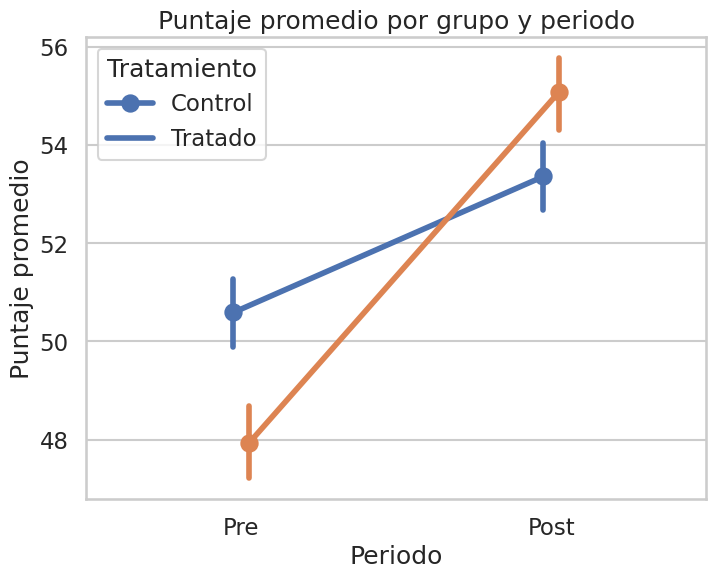

In [24]:
# Gráfico de medias pre/post por grupo

plt.figure(figsize=(8,6))
sns.pointplot(
    data=df_long,
    x="post",
    y="score",
    hue="treated",
    dodge=True,
    errorbar=("ci", 95)
)
plt.xticks([0,1], ["Pre", "Post"])
plt.xlabel("Periodo")
plt.ylabel("Puntaje promedio")
plt.title("Puntaje promedio por grupo y periodo")
plt.legend(title="Tratamiento", labels=["Control", "Tratado"])
plt.show()

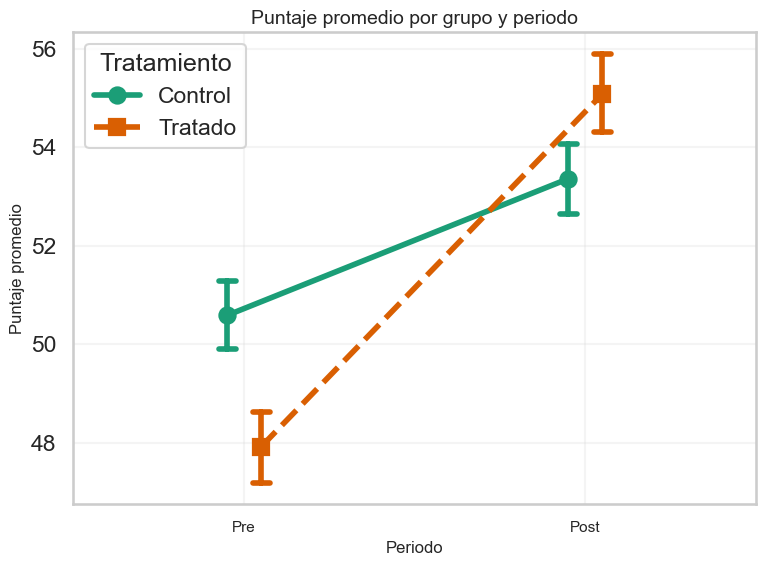

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Paleta con buen contraste (ej. verde vs naranja)
palette = {0: "#1b9e77", 1: "#d95f02"}   # 0=Control, 1=Tratado

sns.pointplot(
    data=df_long,
    x="post",
    y="score",
    hue="treated",
    dodge=0.1,
    errorbar=("ci", 95),
    markers=["o", "s"],          # círculos vs cuadrados
    linestyles=["-", "--"],      # línea continua vs punteada
    palette=palette,
    capsize=0.05                 # “cap” en las barras de error
)

plt.xticks([0, 1], ["Pre", "Post"], fontsize=11)
plt.xlabel("Periodo", fontsize=12)
plt.ylabel("Puntaje promedio", fontsize=12)
plt.title("Puntaje promedio por grupo y periodo", fontsize=14)

# Leyenda clara y en un lugar visible
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles,
           labels=["Control", "Tratado"],
           title="Tratamiento",
           loc="upper left",
           frameon=True)

plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [25]:
# =========================================================
# 3. Cálculo manual de la estimación DiD
# =========================================================

mean_treated_pre  = df_long.query("treated == 1 and post == 0")["score"].mean()
mean_treated_post = df_long.query("treated == 1 and post == 1")["score"].mean()
mean_control_pre  = df_long.query("treated == 0 and post == 0")["score"].mean()
mean_control_post = df_long.query("treated == 0 and post == 1")["score"].mean()

diff_treated = mean_treated_post - mean_treated_pre
diff_control = mean_control_post - mean_control_pre
did_manual   = diff_treated - diff_control

print(f"Diferencia trat (post-pre):  {diff_treated:6.3f}")
print(f"Diferencia ctrl (post-pre):  {diff_control:6.3f}")
print(f"DiD manual (trat - ctrl):    {did_manual:6.3f}")

Diferencia trat (post-pre):   7.154
Diferencia ctrl (post-pre):   2.771
DiD manual (trat - ctrl):     4.383


## 3. Diferencias en Diferencias con regresión lineal (OLS)

Usamos la especificación clásica:

$$
Y_{it} = \alpha + \beta \cdot \text{treated}_i + \gamma \cdot \text{post}_t
       + \delta \cdot (\text{treated}_i \times \text{post}_t) + u_{it}.
$$

La interpretación:

- $\gamma$ es el **cambio promedio** en el grupo control (tendencia común).
- $\delta$ es el **efecto adicional** del tratamiento en el grupo tratado (**impacto causal** bajo el supuesto
  de **tendencias paralelas**).

In [26]:
# =========================================================
# 4. Modelo DiD clásico con statsmodels
# =========================================================

# Creamos la variable de interacción Tratamiento × Post
df_long["treated_post"] = df_long["treated"] * df_long["post"]

# Estimamos el modelo OLS de Diferencias en Diferencias:
# score_it = α + β*treated_i + γ*post_t + δ*(treated_i*post_t) + u_it
did_ols = smf.ols(
    formula="score ~ treated + post + treated_post",  # especificación del modelo
    data=df_long
).fit(cov_type="HC1")  # estimamos con errores estándar robustos tipo HC1

# Mostramos el resumen completo de la regresión
print(did_ols.summary())


                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     69.43
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           3.34e-42
Time:                        22:31:29   Log-Likelihood:                -5469.2
No. Observations:                1600   AIC:                         1.095e+04
Df Residuals:                    1596   BIC:                         1.097e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       50.5898      0.356    142.049   

El coeficiente de `treated_post` es nuestra estimación de $\delta$.  
Si es positivo y significativo, sugiere que la tutoría **incrementó** el puntaje
por encima de la tendencia temporal que ya benefició al grupo control.

### Interpretación del modelo DiD

El modelo estimado es:

$$
\text{score}_{it}
= \beta_0 + \beta_1 \,\text{treated}_i
+ \beta_2 \,\text{post}_t
+ \beta_3 \,(\text{treated}_i \cdot \text{post}_t) + u_{it}.
$$

donde:

- `treated` = 1 si el estudiante está en el grupo tratado, 0 si es control.  
- `post` = 1 en el periodo posterior, 0 en el previo.  
- `treated_post` = `treated * post` es la interacción tratamiento×post.

Con los coeficientes estimados:

- Intercept: $\beta_0 \approx 50.59$
- treated: $\beta_1 \approx -2.66$
- post: $\beta_2 \approx 2.77$
- treated\_post: $\beta_3 \approx 4.38$

---

### 1. Interpretación de cada coeficiente

**Intercept $\beta_0$**

Puntaje promedio del **grupo control en el periodo pre**:

$$
E[\text{score} \mid \text{control, pre}] = \beta_0 \approx 50.59.
$$

**treated $\beta_1$**

Diferencia **inicial (pre)** entre tratado y control.  
Antes de la intervención, el grupo tratado tiene un puntaje promedio:

$$
E[\text{score} \mid \text{tratado, pre}]
= \beta_0 + \beta_1
\approx 50.59 - 2.66
\approx 47.93.
$$

Es decir, los tratados parten **2.66 puntos por debajo** del grupo control.

**post $\beta_2$**

Cambio en el puntaje del **grupo control** entre pre y post:

$$
E[\text{score} \mid \text{control, post}]
= \beta_0 + \beta_2
\approx 50.59 + 2.77
\approx 53.36.
$$

Por tanto, el control mejora aproximadamente **2.77 puntos** solo por el paso del tiempo (maduración, práctica, etc.).

**treated\_post $\beta_3$ – efecto DiD**

Este es el **efecto diferencia–en–diferencias (DiD)**.

- Cambio en el grupo control:

$$
\Delta \text{control}
= (\beta_0 + \beta_2) - \beta_0
= \beta_2
\approx 2.77.
$$

- Cambio en el grupo tratado:

$$
\Delta \text{tratado}
= (\beta_0 + \beta_1 + \beta_2 + \beta_3)
  - (\beta_0 + \beta_1)
= \beta_2 + \beta_3
\approx 2.77 + 4.38
\approx 7.15.
$$

- Diferencia–en–diferencias:

$$
\Delta \text{tratado} - \Delta \text{control}
= \beta_3
\approx 4.38.
$$

**Interpretación**

La capacitación incrementó el puntaje promedio del grupo tratado en alrededor de **4.4 puntos más** que lo que se habría esperado solo por la evolución natural del grupo control.

Además, el p-valor de `treated_post` es prácticamente 0, lo que indica que este efecto es **estadísticamente significativo** (con errores robustos).

---

### eN RESUMEN

- Antes de la capacitación, el grupo tratado estaba peor (≈ 47.9) que el control (≈ 50.6).  
- El grupo control sube ≈ **2.8 puntos** entre pre y post.  
- El grupo tratado sube ≈ **7.1 puntos** entre pre y post.  
- La **ganancia adicional atribuible al tratamiento** es ≈ **4.4 puntos**, capturada por el coeficiente `treated_post`.


## 4. Diferencias en Diferencias con enfoque bayesiano (PyMC)

Ahora implementamos el mismo modelo pero como un **modelo bayesiano**:

$$
\begin{aligned}
Y_{it} &\sim \mathcal{N}(\mu_{it}, \sigma), \\
\mu_{it} &= \alpha + \beta \cdot \text{treated}_i + \gamma \cdot \text{post}_t
          + \delta \cdot (\text{treated}_i \times \text{post}_t).
\end{aligned}
$$

Priors:

- $\alpha, \beta, \gamma, \delta \sim \mathcal{N}(0, 10)$ (débiles, permiten que los datos dominen).
- $\sigma \sim \text{HalfNormal}(10)$ (escala positiva, moderadamente amplia).

Con estos priors estamos diciendo, de forma vaga, que los efectos pueden ser grandes pero no enormes,
y que el error tiene desvío estándar razonable.

### 5. Modelo bayesiano de diferencias-en-diferencias (DiD) con PyMC

En esta sección formulamos un modelo **bayesiano** que replica el clásico modelo de diferencias-en-diferencias:

$$
\text{score}_{it}
= \alpha
+ \beta \,\text{treated}_i
+ \gamma \,\text{post}_t
+ \delta \,(\text{treated}_i \cdot \text{post}_t)
+ \varepsilon_{it},
$$

donde:

- `score` es el puntaje del estudiante \(i\) en el periodo \(t\).
- `treated` es una dummy de tratamiento:
  - $ \text{treated}_i = 1 $ si el estudiante está en el grupo tratado,  
  - $ \text{treated}_i = 0 $ si está en el grupo de control.
- `post` es una dummy de tiempo:
  - $ \text{post}_t = 1 $ en el periodo posterior a la intervención,  
  - $ \text{post}_t = 0 $ en el periodo previo.
- `treated_post = treated \times post` es la **interacción** tratamiento×tiempo.

La interpretación de los parámetros es la misma que en el DiD clásico:

- $ \alpha $: media del **grupo control en el periodo pre**.  
- $ \beta $: diferencia inicial (pre) entre tratado y control.  
- $ \gamma $: cambio del **control** entre pre y post (efecto del tiempo).  
- $ \delta $: **efecto DiD**, es decir, cuánto más cambia el grupo tratado respecto al control:
  $$
  \delta =
  \big(\Delta \text{tratado}\big) - \big(\Delta \text{control}\big).
  $$

---

### 5.1. Especificación bayesiana

En lugar de estimar los parámetros por mínimos cuadrados, les asignamos **distribuciones a priori** y usamos inferencia bayesiana.

1. **Priors sobre los coeficientes**

Cada parámetro del modelo tiene un prior Normal:

$$
\alpha \sim \mathcal{N}(0, 10^2), \quad
\beta  \sim \mathcal{N}(0, 10^2), \quad
\gamma \sim \mathcal{N}(0, 10^2), \quad
\delta \sim \mathcal{N}(0, 10^2).
$$

Estos priors son relativamente **débiles** (varianza grande), centrados en 0, lo que significa que antes de ver los datos no asumimos efectos grandes ni en una dirección específica.

2. **Prior sobre la desviación estándar del error**

Suponemos errores normales homocedásticos con desviación estándar \(\sigma\) y usamos un prior Half-Normal (sólo valores positivos):

$$
\sigma \sim \text{HalfNormal}(10).
$$

3. **Modelo de verosimilitud (likelihood)**

Condicional a $\alpha, \beta, \gamma, \delta, \sigma$, el puntaje observado sigue:

$$
\mu_{it}
= \alpha
+ \beta \,\text{treated}_i
+ \gamma \,\text{post}_t
+ \delta \,(\text{treated}_i \cdot \text{post}_t),
$$

$$
\text{score}_{it} \mid \alpha,\beta,\gamma,\delta,\sigma
\sim \mathcal{N}(\mu_{it}, \sigma^2).
$$

En el código:

- `mu = alpha + beta*treated + gamma*post + delta*treated_post`
- `score_like = pm.Normal(..., mu=mu, sigma=sigma, observed=y_obs)`

---

### 5.2. Inferencia con MCMC (NUTS)

Usamos PyMC para aproximar la **distribución posterior** de todos los parámetros:

$$
p(\alpha,\beta,\gamma,\delta,\sigma \mid \text{datos}).
$$

El muestreador empleado es **NUTS** (No-U-Turn Sampler), una variante eficiente de Hamiltonian Monte Carlo.

En el código:

- `draws=2000`, `tune=1000`, `chains=4`  
  → se generan 4 cadenas con 1000 iteraciones de calentamiento y 2000 muestras posteriores cada una.
- `target_accept=0.9` ajusta la tasa de aceptación para mejorar la estabilidad.

A partir del objeto `trace` podemos:

- Resumir la posterior de $\delta$ (efecto causal DiD).  
- Calcular intervalos de credibilidad (HDI) para \(\delta\).  
- Obtener la probabilidad posterior de un efecto positivo:  
  $$
  P(\delta > 0 \mid \text{datos}).
  $$

Este enfoque permite interpretar el impacto del programa de forma completamente bayesiana, incorporando la incertidumbre sobre los parámetros y proporcionando medidas directas de probabilidad sobre el tamaño y signo del efecto.


In [27]:
# =========================================================
# 5. Modelo bayesiano DiD con PyMC
# =========================================================

# Matriz de diseño simple con intercepto implícito en el modelo
treated = df_long["treated"].values
post    = df_long["post"].values
treated_post = df_long["treated_post"].values
y_obs   = df_long["score"].values

with pm.Model() as did_bayes:

    # Priors sobre los coeficientes
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta  = pm.Normal("beta",  mu=0, sigma=10)  # efecto de treated (en periodo pre)
    gamma = pm.Normal("gamma", mu=0, sigma=10)  # efecto de post en el grupo control
    delta = pm.Normal("delta", mu=0, sigma=10)  # efecto de DiD (impacto causal)

    # Prior sobre la desviación estándar del error
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Media lineal
    mu = alpha + beta*treated + gamma*post + delta*treated_post

    # Likelihood
    score_like = pm.Normal("score_like", mu=mu, sigma=sigma, observed=y_obs)

    # Muestreo MCMC con NUTS
    trace = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=123,
        return_inferencedata=True
    )

Output()

In [28]:
# Resumen de la posterior
az.summary(trace, var_names=["alpha", "beta", "gamma", "delta", "sigma"], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,50.518,0.369,49.846,51.226,0.007,0.004,2957.016,4197.046,1.000
beta,-2.581,0.530,-3.569,-1.606,0.010,0.006,3064.685,4147.152,1.001
gamma,2.841,0.526,1.862,3.841,0.010,0.006,2884.775,4539.762,1.000
delta,4.300,0.753,2.953,5.778,0.014,0.009,2797.276,4092.084,1.000
sigma,7.395,0.133,7.146,7.646,0.002,0.001,5882.095,5193.588,1.000


### Resumen de la tabla `az.summary`

Cada fila es un parámetro del modelo bayesiano (`alpha`, `beta`, `gamma`, `delta`, `sigma`) y las columnas son:

- **mean**: media de la distribución posterior (estimador bayesiano del parámetro).
- **sd**: desviación estándar de la posterior (incertidumbre alrededor de la media).
- **hdi_3% – hdi_97%**: límites del intervalo de credibilidad (HDI) al 94%.  
  Ej.: para `delta`, el efecto DiD “más creíble” está en ese rango.
- **mcse_mean / mcse_sd**: error Monte Carlo de la media y de la sd  
  (qué tanto error proviene del número finito de muestras MCMC; mientras más pequeño, mejor).
- **ess_bulk / ess_tail**: tamaño de muestra efectivo en la parte central y en las colas de la posterior  
  (valores grandes ⇒ cadenas informativas y bien mezcladas).
- **r_hat**: diagnóstico de convergencia; valores muy cercanos a 1 indican buena convergencia del muestreo.

En conjunto, la tabla resume **valor, incertidumbre e indicadores de calidad del muestreo** para cada parámetro.


El parámetro clave es `delta`.  
Nos interesan:

- Su **media / mediana posterior** (estimación del efecto).
- Su **intervalo de credibilidad** (por ejemplo 94% HDI).
- La **probabilidad posterior** de que el efecto sea positivo, \(P(\delta > 0 \mid datos)\).

In [29]:
# Intervalo de credibilidad y probabilidad de efecto positivo

delta_samples = trace.posterior["delta"].values.flatten()

# HDI 94% como array de longitud 2: [baja, alta]
hdi_delta = az.hdi(delta_samples, hdi_prob=0.94)
hdi_low, hdi_high = hdi_delta[0], hdi_delta[1]

prob_delta_pos = (delta_samples > 0).mean()

print("Delta (DiD) - media posterior: ", delta_samples.mean())
print("Delta (DiD) - 94% HDI:        ", hdi_low, "a", hdi_high)
print("Probabilidad posterior delta > 0: ", prob_delta_pos)


Delta (DiD) - media posterior:  4.300215854304568
Delta (DiD) - 94% HDI:         2.9534949142678717 a 5.778327871397041
Probabilidad posterior delta > 0:  1.0


In [30]:
print(f"Delta (DiD) - media posterior:      {delta_samples.mean():.3f}")
print(f"Delta (DiD) - 94% HDI:             [{hdi_low:.3f}, {hdi_high:.3f}]")
print(f"Probabilidad posterior delta > 0:   {prob_delta_pos:.3f}")


Delta (DiD) - media posterior:      4.300
Delta (DiD) - 94% HDI:             [2.953, 5.778]
Probabilidad posterior delta > 0:   1.000


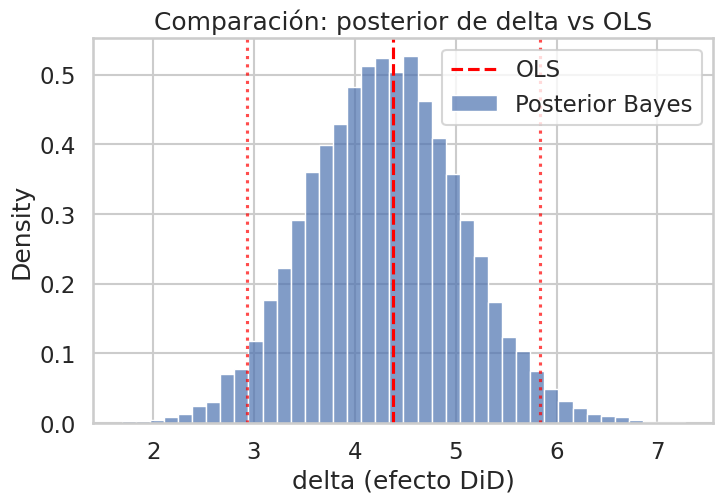

In [31]:
# Distribución posterior de delta vs estimación OLS

delta_ols = did_ols.params["treated_post"]
ci_ols = did_ols.conf_int().loc["treated_post"].values

plt.figure(figsize=(8,5))
sns.histplot(delta_samples, bins=40, stat="density", alpha=0.7, label="Posterior Bayes")
plt.axvline(delta_ols, color="red", linestyle="--", label="OLS")
plt.axvline(ci_ols[0], color="red", linestyle=":", alpha=0.7)
plt.axvline(ci_ols[1], color="red", linestyle=":", alpha=0.7)
plt.xlabel("delta (efecto DiD)")
plt.title("Comparación: posterior de delta vs OLS")
plt.legend()
plt.show()

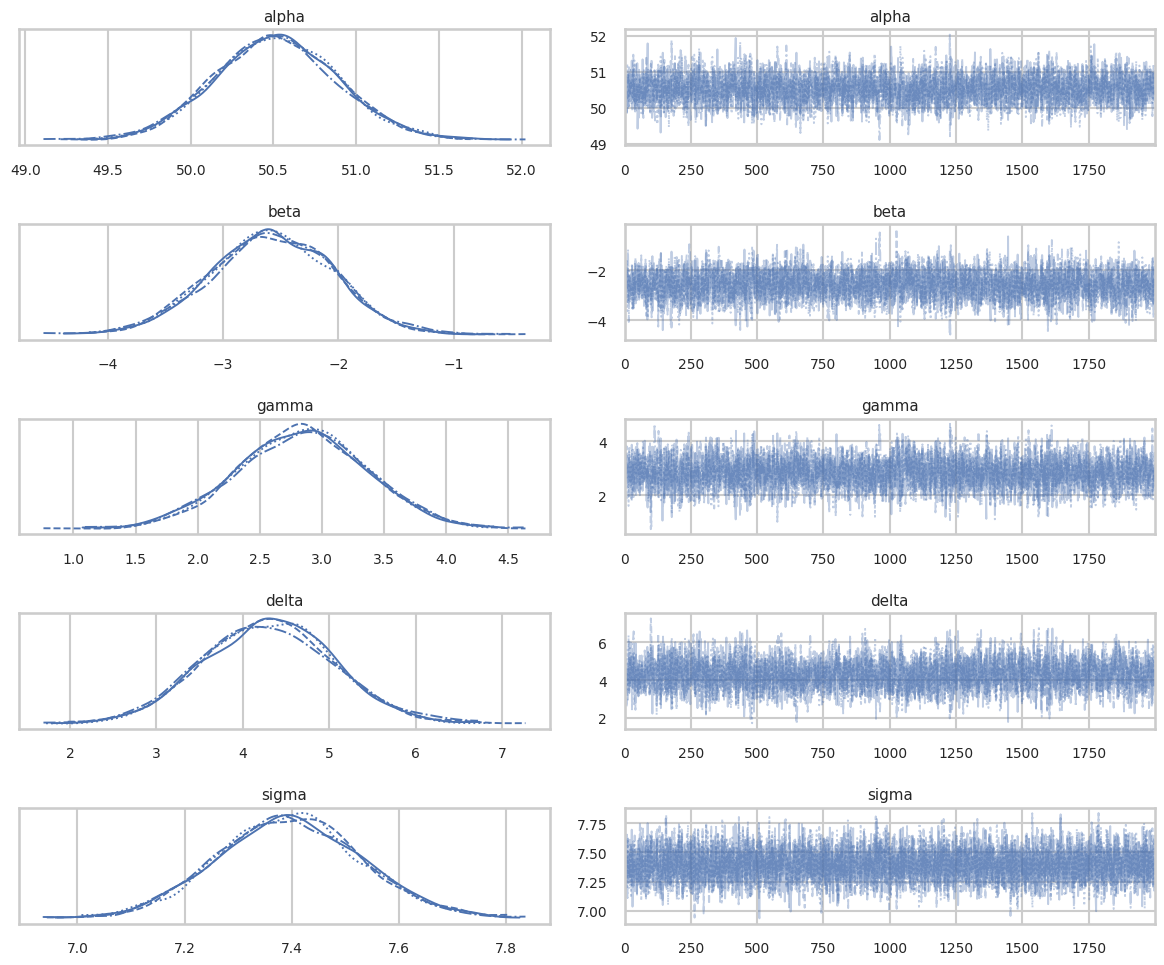

In [32]:
az.plot_trace(trace, var_names=["alpha", "beta", "gamma", "delta", "sigma"])
plt.tight_layout()
plt.show()


### Interpretación del gráfico `plot_trace` del modelo DiD bayesiano

El gráfico muestra, para cada parámetro del modelo bayesiano de diferencias-en-diferencias,

$$
\text{score}_{it}
= \alpha
+ \beta\,\text{treated}_i
+ \gamma\,\text{post}_t
+ \delta\,(\text{treated}_i \cdot \text{post}_t)
+ \varepsilon_{it},
$$

dos paneles:

- **Columna izquierda:** distribución posterior (densidad) del parámetro.  
- **Columna derecha:** trayectoria MCMC de las 4 cadenas (valor del parámetro en cada iteración).

#### 1. Convergencia y mezcla de las cadenas

En los paneles de la derecha (para α, β, γ, δ y σ):

- Las cadenas se ven **estacionarias** (no hay tendencia clara hacia arriba o abajo a lo largo de las iteraciones).
- Las diferentes cadenas se **superponen** y recorren la misma región de valores.
- No se observan “saltos” bruscos ni cadenas pegadas en un solo valor.

Visualmente esto sugiere que el muestreador NUTS ha **convergido** y que la mezcla es razonablemente buena.  
(Se puede complementar con `az.summary` para ver \( \hat{R} \) cercano a 1 y tamaños efectivos grandes).

#### 2. Distribuciones posteriores de los coeficientes

En la columna izquierda:

- **α (alpha)**  
  La densidad posterior está centrada en torno a ≈ 50.5 con forma casi normal y relativamente concentrada.  
  Interpreta el **puntaje medio del grupo control en el periodo pre**:
  $$E[\text{score} \mid \text{control, pre}] \approx \alpha.$$

- **β (beta)**  
  Distribución centrada en un valor negativo (≈ −2.5), también bastante concentrada.  
  Indica que, antes de la intervención, el grupo tratado tenía un puntaje **menor** que el control:
  $$E[\text{score} \mid \text{tratado, pre}] \approx \alpha + \beta < \alpha.$$

- **γ (gamma)**  
  Posterior centrada alrededor de ≈ 2.7–3.0.  
  Representa el cambio medio del **grupo control** entre pre y post:
  $$\Delta \text{control} \approx \gamma.$$

- **δ (delta)**  
  La densidad posterior está desplazada claramente hacia valores **positivos**, con poca masa cerca de 0.  
  Este es el **efecto DiD**:

  $\delta = (\Delta _{tratado}) - (\Delta _{control})$  


  Que la mayor parte de la masa posterior de $\delta$ esté por encima de 0 sugiere **alta probabilidad** de que el tratamiento tenga un efecto positivo sobre el puntaje.

- **σ (sigma)**  
  La distribución posterior de σ es unimodal y relativamente estrecha: indica una estimación razonablemente precisa de la **desviación estándar del error** del modelo (variabilidad residual no explicada por las dummies de tratamiento y tiempo).



### Posterior de delta (efecto DiD) con HDI

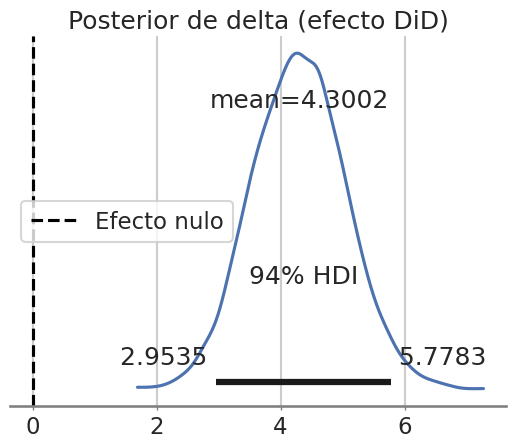

In [33]:
az.plot_posterior(
    trace,
    var_names=["delta"],
    hdi_prob=0.94,
    round_to=5
)
plt.axvline(0, color="black", linestyle="--", label="Efecto nulo")
plt.title("Posterior de delta (efecto DiD)")
plt.legend()
plt.show()


## 5. Interpretación y comparación de enfoques

### Diferencias en Diferencias (OLS clásico)

- La estimación de `treated_post` en el modelo OLS nos da un valor puntual de \(\hat{\delta}\) y su
  intervalo de confianza (IC) al 95%.
- La interpretación es: *bajo el supuesto de tendencias paralelas*, el efecto promedio de la tutoría sobre
  el puntaje del examen externo es de aproximadamente \(\hat{\delta}\) puntos.
- El IC indica el rango de valores compatibles con los datos si repitiésemos el experimento muchas veces.

### Diferencias en Diferencias (Bayesiano)

- En el modelo bayesiano, `delta` también mide el efecto causal, pero ahora tenemos una **distribución posterior**
  completa para ese parámetro.
- Podemos reportar:
  - Media/mediana posterior como estimación puntual.
  - Intervalo de credibilidad (HDI) 94% como rango de valores plausibles *dados los datos y los priors*.
  - Probabilidad posterior \(P(\delta > 0 \mid datos)\), que responde directamente a la pregunta:
    > ¿Qué tan probable es que la tutoría haya tenido un efecto positivo?

En general, si los priors son débiles, los resultados OLS y Bayesianos deberían ser bastante similares.
La ventaja bayesiana es que:

- Trabaja con distribuciones completas, no solo con puntos e IC asintóticos.
- Permite incorporar información previa de expertos o estudios anteriores en los priors.
- Facilita el cálculo de probabilidades sobre el efecto (p.ej., \(P(\delta > 2)\)).

## 6. Extensiones posibles para un proyecto más grande

Para un proyecto final de evaluación de impacto, podrías extender este cuaderno con:

1. **Variables adicionales de control** (características de estudiante/colegio) para mejorar la precisión.
2. **Efectos fijos de colegio** (agrupación): DiD con panel y `entity + time fixed effects`.
3. **Heterogeneidad de impacto**: permitir que \(\delta\) varíe por nivel socioeconómico, género, etc.
4. **Otros métodos de evaluación** para comparar:
   - Before/After sin control (para mostrar por qué es sesgado).
   - Matching + DiD (combinar emparejamiento y método de diferencias).
   - Modelos jerárquicos bayesianos (efectos aleatorios por colegio).

La estructura básica que ya construimos (datos panel, DiD clásico, DiD bayesiano) te da un punto de partida
sólido para desarrollar una aplicación más rica en tu propio contexto (por ejemplo, usando datos reales
de evaluaciones educativas o programas de tutoría).